# Análise Preço de Petróleo

## Apresentação

### 👥 Integrantes
* Marlon Jobim Fernandez (RM353490)
* Roberto Cavedon Muller (RM353491)

### 🎯 Proposta do Trabalho
Analisar a série histórica de preços do petróleo tipo Brent e elaborar um relatório que aborde:
* A variação de preços ao longo do tempo
* A projeção de preços futuros com o uso de técnicas de Machine Learning

### 📌 Levantamento Prévio de Informações
O petróleo é uma commodity internacional e uma das principais matérias-primas energéticas do planeta, com forte influência na economia global.

Apesar da existência de diferentes tipos de petróleo — com variações conforme a região e método de extração — o foco desta análise será o tipo Brent, cujo preço é definido diariamente em bolsas internacionais.

### 🔍 Fatores que influenciam o preço do Brent:
* Preço de referência estabelecido pela OPEP (Organização dos Países Exportadores de Petróleo)

* Volume de produção e estoque global

* Variações na demanda internacional

* Geopolítica: conflitos, guerras, embargos e crises diplomáticas

Embora muitos desses fatores sejam imprevisíveis no curto ou longo prazo (como início ou fim de guerras), é possível que existam padrões sazonais e ciclos econômicos que influenciam o comportamento da série de preços.

### 📈 Justificativa da Análise
* A aplicação de técnicas de Análise de Dados e Machine Learning pode:

* Confirmar a existência de padrões temporais recorrentes

* Identificar tendências ou rupturas associadas a eventos econômicos ou sazonais

* Fornecer uma base estatística sólida para apoiar tomadas de decisão, reduzindo incertezas e riscos



# Imports

In [2]:
import ipeadatapy as ip
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from xgboost import XGBRegressor
import joblib

## 1. Extração dos dados e Análise inicial

O IPEADATA possui uma biblioteca em python, a [ipeadatapy]([text](https://www.luanborelli.net/ipeadatapy/docs/about.html)).<br>
Esta biblioteca é uma facilitadora de dados tratados e limpos para análise de dados temporais. <br>
Possui duas bibliotecas dependentes para sua instalação:
 * Pandas
 * Requests

O Dataframe será criando chamado a função e definindo a commodity **EIA366_PBRENT366** a partir do ano **1999**.
 

In [3]:
df = ip.timeseries('EIA366_PBRENT366', yearGreaterThan=1999)
df = df.rename(columns={'VALUE (US$)': 'Preco_Brent'})
df.index = pd.to_datetime(df.index)
df = df.sort_index().dropna()
df = df[['Preco_Brent']]

Dataframe criado com as váriaveis target para criação da time series.

In [4]:
df.head()

,Preco_Brent
DATE,
2000-01-04,23.95
2000-01-05,23.72
2000-01-06,23.55
2000-01-07,23.35
2000-01-10,22.77


### 1.2 Visualização da série completa

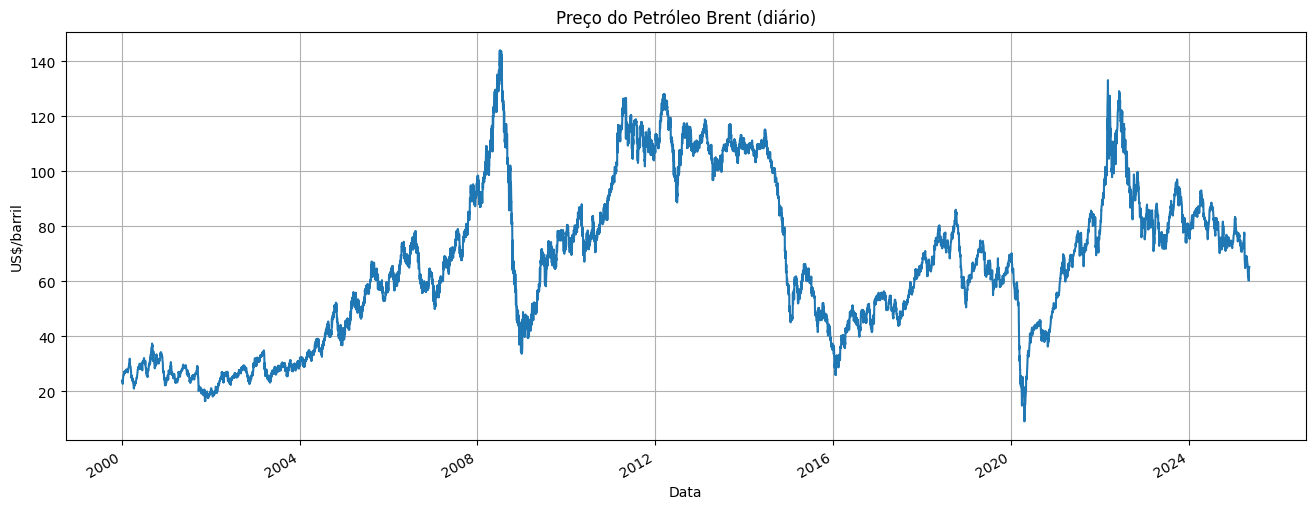

In [5]:
df['Preco_Brent'].plot(figsize=(16, 6), title='Preço do Petróleo Brent (diário)')
plt.ylabel('US$/barril')
plt.xlabel('Data')
plt.grid(True)
plt.show()

### 1.3 Estatísticas descritivas

In [6]:
print("Estatísticas descritivas:")
print(df['Preco_Brent'].describe())

Estatísticas descritivas:
count    8220.000000
mean       67.341462
std        28.830712
min         9.120000
25%        44.980000
50%        65.240000
75%        86.552500
max       143.950000
Name: Preco_Brent, dtype: float64


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8220 entries, 2000-01-04 to 2025-05-12
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Preco_Brent  8220 non-null   float64
dtypes: float64(1)
memory usage: 128.4 KB


## 2. Análiste estatística

### 2.1 Média Móvel


Para iniciar a análise desta séria temporal, iremos definir média móvel em duas janelas:

 * **7 Dias**: Para capturar movimentos a curto prazo
 * **30 dias**: Calcular uma janela maior para definir uma trend mais estável

In [8]:
df['MM_7'] = df['Preco_Brent'].rolling(window=7).mean()
df['MM_30'] = df['Preco_Brent'].rolling(window=30).mean()

Visualizar a serie temporal junto com as médias móveis.

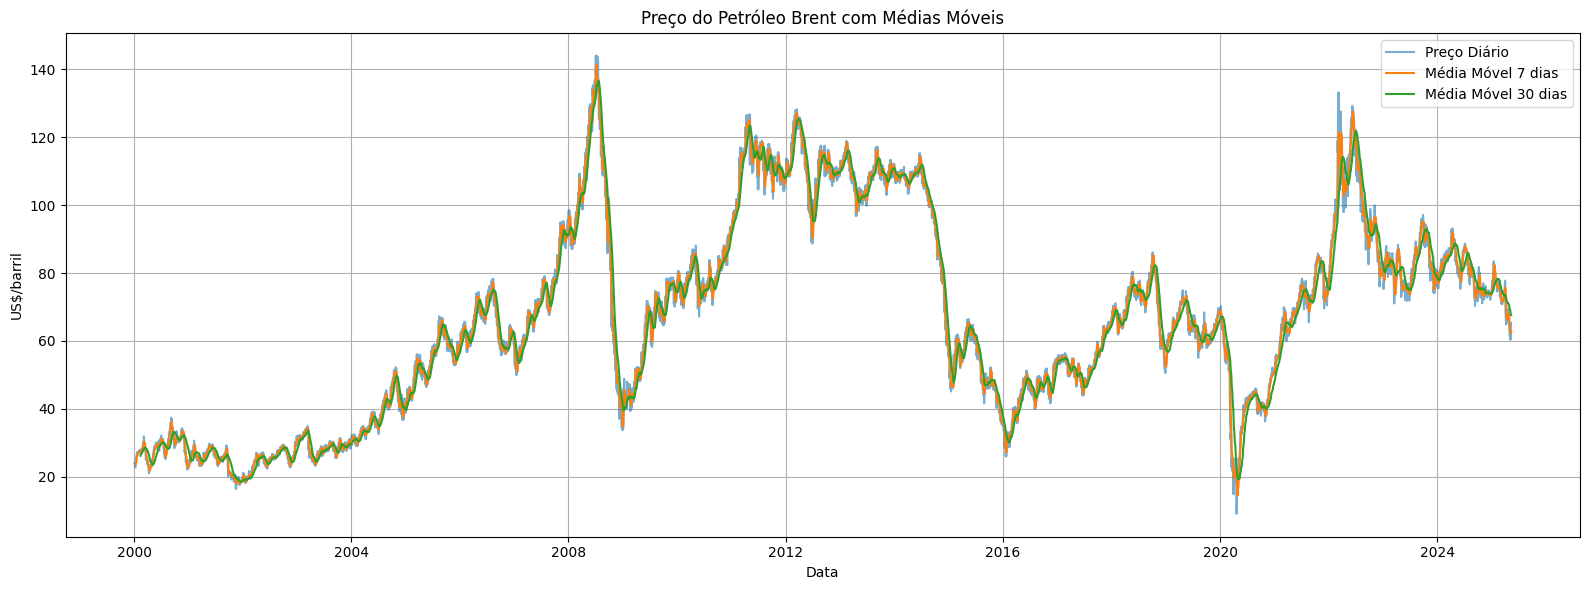

In [29]:
plt.figure(figsize=(16, 6))
plt.plot(df['Preco_Brent'], label='Preço Diário', alpha=0.6)
plt.plot(df['MM_7'], label='Média Móvel 7 dias')
plt.plot(df['MM_30'], label='Média Móvel 30 dias')
plt.title('Preço do Petróleo Brent com Médias Móveis')
plt.xlabel('Data')
plt.ylabel('US$/barril')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 2.2 Análise de volatidade e outliers

Vamos adicionar mais alguns dados estatísticos para entender melhor o comportamento desta série temporal.<br>
 * Desvio padrão geral e mensal para identificar se a volatilidade muda com o tempo
 * Identificar picos históricos
 * Detectar outliers usando o método IQR

In [30]:
# Desvio padrão geral
print(f"Desvio padrão total: {df['Preco_Brent'].std():.2f}")

# Desvio padrão mensal
desvio_mensal = df['Preco_Brent'].resample('ME').std()
print("\nDesvio padrão mensal (últimos 12 meses):")
print(desvio_mensal[-12:])

# Máximo e mínimo
print(f"\nPico máximo: {df['Preco_Brent'].max():.2f} em {df['Preco_Brent'].idxmax().date()}")
print(f"Pico mínimo: {df['Preco_Brent'].min():.2f} em {df['Preco_Brent'].idxmin().date()}")

# Outliers via IQR
Q1 = df['Preco_Brent'].quantile(0.25)
Q3 = df['Preco_Brent'].quantile(0.75)
IQR = Q3 - Q1
limite_inf = Q1 - 1.5 * IQR
limite_sup = Q3 + 1.5 * IQR

outliers = df[(df['Preco_Brent'] < limite_inf) | (df['Preco_Brent'] > limite_sup)]
print(f"\nNúmero de outliers detectados: {len(outliers)}")

# Visualiza os outliers
print("Exemplos de outliers:")
print(outliers.head())


Desvio padrão total: 28.83

Desvio padrão mensal (últimos 12 meses):
DATE
2024-06-30    4.182580
2024-07-31    2.758540
2024-08-31    1.828867
2024-09-30    1.928705
2024-10-31    2.862801
2024-11-30    1.231538
2024-12-31    0.698737
2025-01-31    2.362619
2025-02-28    1.139897
2025-03-31    1.596205
2025-04-30    3.779253
2025-05-31    1.657738
Freq: ME, Name: Preco_Brent, dtype: float64

Pico máximo: 143.95 em 2008-07-03
Pico mínimo: 9.12 em 2020-04-21

Número de outliers detectados: 0
Exemplos de outliers:
Empty DataFrame
Columns: [Preco_Brent, MM_7, MM_30, Preco_Brent_diff, Preco_diff]
Index: []


Não identificamos outliers com o método de distância interquartil(IQR). Ainda que tivemos máximas e minima distantes da médiana, não temos detectamos volatilidade, apontando uma distribuição suave e estável na serie.

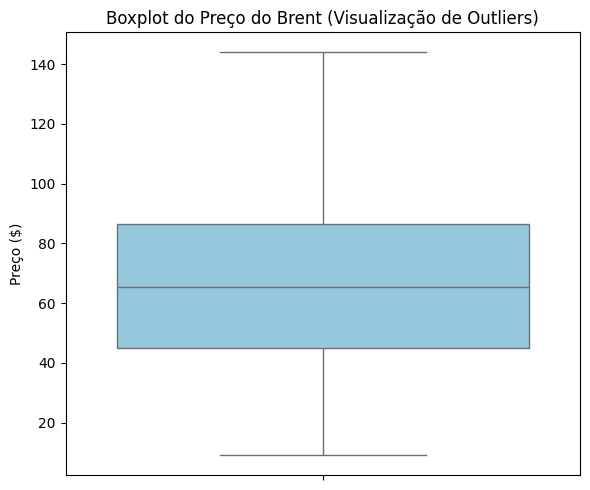

In [31]:
plt.figure(figsize=(6, 5))
sns.boxplot(y=df['Preco_Brent'], color='skyblue')
plt.title('Boxplot do Preço do Brent (Visualização de Outliers)')
plt.ylabel('Preço ($)')
plt.tight_layout()
plt.show()


### 2.3 Segmentação da Série Histórica


Iremos agora separar nossa série história em períodos menores com a intenção de analisar qual o periódo mais adequado para um modelo de previsão.

In [32]:
df_2y = df[df.index >= df.index.max() - pd.DateOffset(years=2)]
df_5y = df[df.index >= df.index.max() - pd.DateOffset(years=5)]
df_10y = df[df.index >= df.index.max() - pd.DateOffset(years=10)]

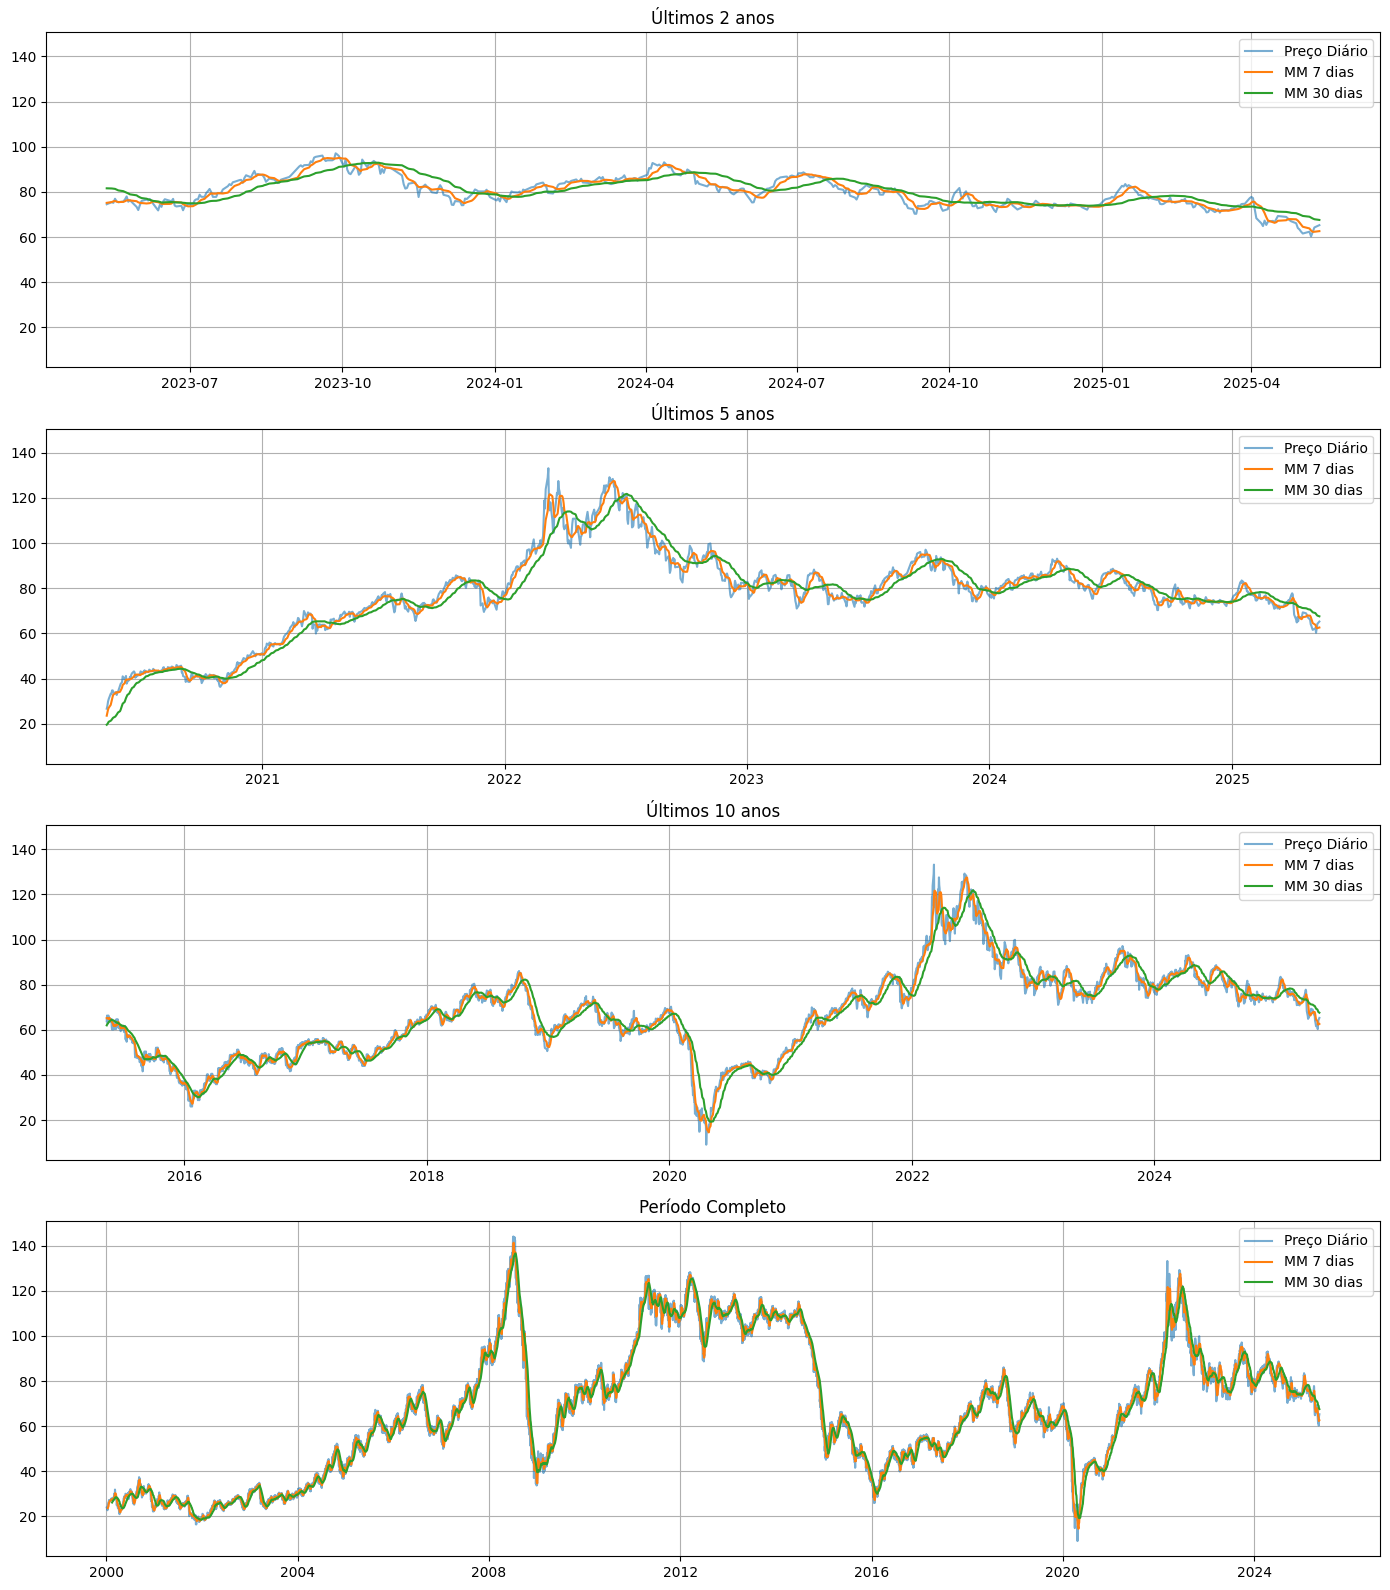

In [33]:
fig, axs = plt.subplots(4, 1, figsize=(14, 16), sharey=True)

for ax, data, title in zip(
    axs,
    [df_2y, df_5y, df_10y, df],
    ["Últimos 2 anos", "Últimos 5 anos", "Últimos 10 anos", "Período Completo"]
):
    ax.plot(data['Preco_Brent'], label='Preço Diário', alpha=0.6)
    ax.plot(data['MM_7'], label='MM 7 dias')
    ax.plot(data['MM_30'], label='MM 30 dias')
    ax.set_title(title)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

🔹 **Janela de 2 anos** <br>
**Comportamento**: Padrão relativamente estável, com uma leve tendência de queda entre 2024 e 2025. Pouca oscilação extrema.

 * ✅ Vantagem : Ideal para modelos que focam em comportamento recente e curto prazo.

 * ⚠️ Limitação: Curto espaço temporal, com poucos dados para capturar padrões sazonais ou eventos externos significativos.

 🔹 **Janela de 5 anos** <br>
**Comportamento**: Inclui o choque do petróleo em 2022 (pós-pandemia e início da guerra na Ucrânia). Exibe ciclos de recuperação e queda, com boa variação nos dados.

 * ✅ Vantagem: Oferece um bom equilíbrio entre dados recentes e contexto econômico relevante.

 * ⚠️ Limitação: Ainda pode estar influenciada por eventos atípicos recentes, o que pode afetar a generalização do modelo.

 🔹 **Janela de 10 anos** <br>
**Comportamento**: Engloba a queda de 2015–2016, uma recuperação progressiva, o colapso da COVID-19 em 2020 e o pico de preços em 2022.

 * ✅ Vantagem: Abrange ciclos econômicos completos e diferentes regimes de mercado, ideal para modelos de longo prazo.

 * ⚠️ Limitação: Pode diluir padrões mais recentes, exigindo técnicas de diferenciação ou ajustes adicionais no modelo.

✅ **Conclusão** <br>
Diante dos padrões analisados, optamos por seguir com a janela de 5 anos, pois ela permite capturar o comportamento recente com um bom nível de variação, sendo mais adequada para um modelo de previsão de curto prazo.

### 2.5 Dickey-Fuller

Vamos agora realizar o teste Dickey-Fuller para identificar se as propriedades estatísticas de média, variância e autocorrelação permanecem constantes com o tempo.

#### 2.5.1 Criando função e testando estacionariedade 

In [34]:
def testar_estacionariedade(serie, nome_serie):
    resultado = adfuller(serie.dropna())
    print(f"\nTeste ADF - {nome_serie}")
    print(f"ADF Statistic: {resultado[0]:.4f}")
    print(f"p-value: {resultado[1]:.4f}")
    print("Conclusão:", "Estacionária" if resultado[1] < 0.05 else "Não estacionária")

# Segmenta as janelas
df_2y = df[df.index >= df.index.max() - pd.DateOffset(years=2)]
df_5y = df[df.index >= df.index.max() - pd.DateOffset(years=5)]
df_10y = df[df.index >= df.index.max() - pd.DateOffset(years=10)]

# Executa o teste
testar_estacionariedade(df_2y['Preco_Brent'], 'Últimos 2 anos')
testar_estacionariedade(df_5y['Preco_Brent'], 'Últimos 5 anos')
testar_estacionariedade(df_10y['Preco_Brent'], 'Últimos 10 anos')



Teste ADF - Últimos 2 anos
ADF Statistic: -1.9895
p-value: 0.2912
Conclusão: Não estacionária

Teste ADF - Últimos 5 anos
ADF Statistic: -2.3274
p-value: 0.1633
Conclusão: Não estacionária

Teste ADF - Últimos 10 anos
ADF Statistic: -2.2870
p-value: 0.1762
Conclusão: Não estacionária


| Janela  | ADF Statistic | p-value | Conclusão          |
| ------- | ------------- | ------- | ------------------ |
| 2 anos  | -1.9895       | 0.2912  | ❌ Não estacionária |
| 5 anos  | -2.3274       | 0.1633  | ❌ Não estacionária |
| 10 anos | -2.2870       | 0.1762  | ❌ Não estacionária |


Como tivemos o resultado de que as séries não estão estacionárias, vamos aplicar a diferenciação de 1º ordem

#### 2.5.2 Diferenciação de 1º ordem

In [35]:
df['Preco_Brent_diff'] = df['Preco_Brent'].diff()
testar_estacionariedade(df['Preco_Brent_diff'][-2*365:], 'Últimos 2 anos - Diferenciado')
testar_estacionariedade(df['Preco_Brent_diff'][-5*365:], 'Últimos 5 anos - Diferenciado')
testar_estacionariedade(df['Preco_Brent_diff'][-10*365:], 'Últimos 10 anos - Diferenciado')



Teste ADF - Últimos 2 anos - Diferenciado
ADF Statistic: -8.4127
p-value: 0.0000
Conclusão: Estacionária

Teste ADF - Últimos 5 anos - Diferenciado
ADF Statistic: -19.4815
p-value: 0.0000
Conclusão: Estacionária

Teste ADF - Últimos 10 anos - Diferenciado
ADF Statistic: -12.9411
p-value: 0.0000
Conclusão: Estacionária


| Janela  | ADF Statistic | p-value | Conclusão      |
| ------- | ------------- | ------- | -------------- |
| 2 anos  | -8.4127       | 0.0000  | ✅ Estacionária |
| 5 anos  | -19.4815      | 0.0000  | ✅ Estacionária |
| 10 anos | -12.9411      | 0.0000  | ✅ Estacionária |

 * Os p-values são < 0.05 → Rejeitamos a hipótese nula de não-estacionariedade.

* A diferenciação de 1ª ordem foi suficiente para estabilizar a série em todas as janelas analisadas.

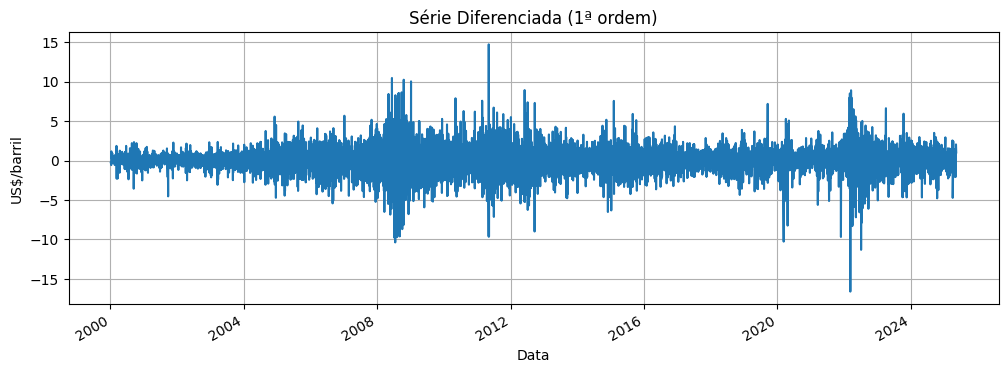

In [36]:
df['Preco_diff'] = df['Preco_Brent'].diff()
df['Preco_diff'].plot(title='Série Diferenciada (1ª ordem)', figsize=(12, 4))
plt.ylabel('US$/barril')
plt.xlabel('Data')
plt.grid(True)


### 2.6 ACF e PACF

Precisamos agora explorar ACF e PACF para identificamos os parâmetros de autoregressão e média móvel (p,q), focando na série de 5 anos.

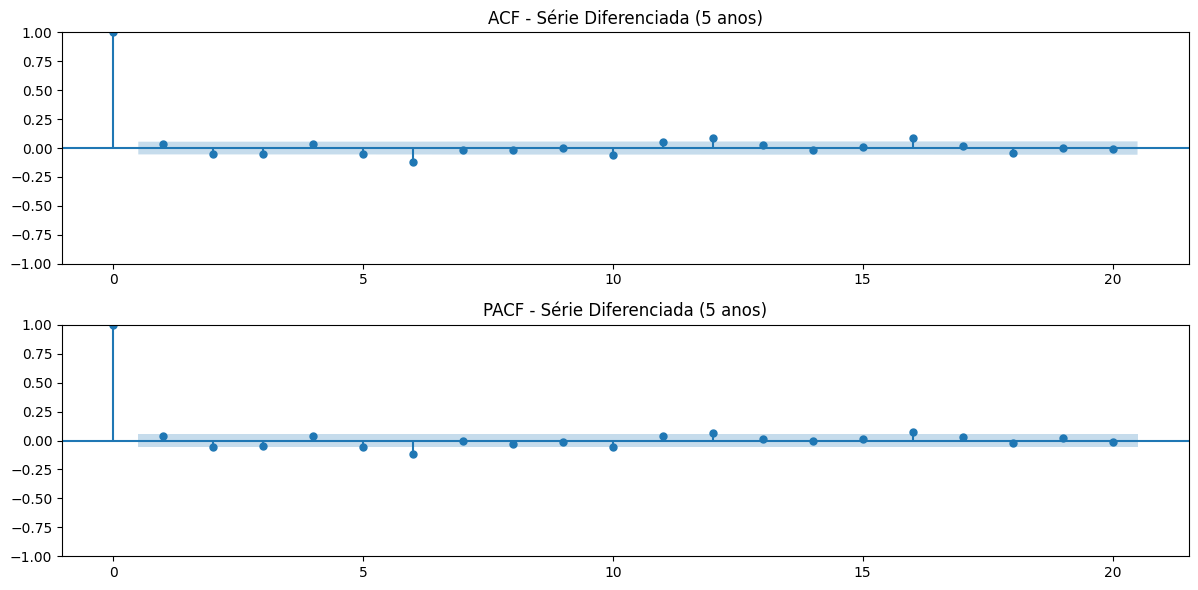

In [37]:
# Série diferenciada (5 anos)
serie_diff_5y = df['Preco_Brent'].diff().dropna()
serie_diff_5y = serie_diff_5y[serie_diff_5y.index >= df.index.max() - pd.DateOffset(years=5)]

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

plot_acf(serie_diff_5y, ax=axs[0], lags=20)
axs[0].set_title('ACF - Série Diferenciada (5 anos)')

plot_pacf(serie_diff_5y, ax=axs[1], lags=20, method='ywm')
axs[1].set_title('PACF - Série Diferenciada (5 anos)')

plt.tight_layout()
plt.show()


ACF - O lag1 está bem acima da banda de confiança, indicando forte autocorrelação imediata.<br>
PACF - Assim como ACF, o lag 1 aparece destacado<br>
Seguirmos com ARIMA(1,1,1), separando 80% dos dados para treino

In [38]:
df_5y = df[df.index >= df.index.max() - pd.DateOffset(years=5)]
serie = df_5y['Preco_Brent'].dropna()
serie = serie.asfreq('D')
serie = serie.interpolate()

serie_diff = serie.diff().dropna()

split_index = int(len(serie_diff) * 0.8)
train, test = serie_diff[:split_index], serie_diff[split_index:]

print(f"Tamanho treino: {len(train)}")
print(f"Tamanho teste: {len(test)}")


Tamanho treino: 1460
Tamanho teste: 366


## 3 Módelos de Previsão

### 3.1 ARIMA

#### 3.1.1 ARIMA(1,1,1)

Iniciaremos os testes com os parametros ARIMA(1,1,1)

RMSE: 8.99


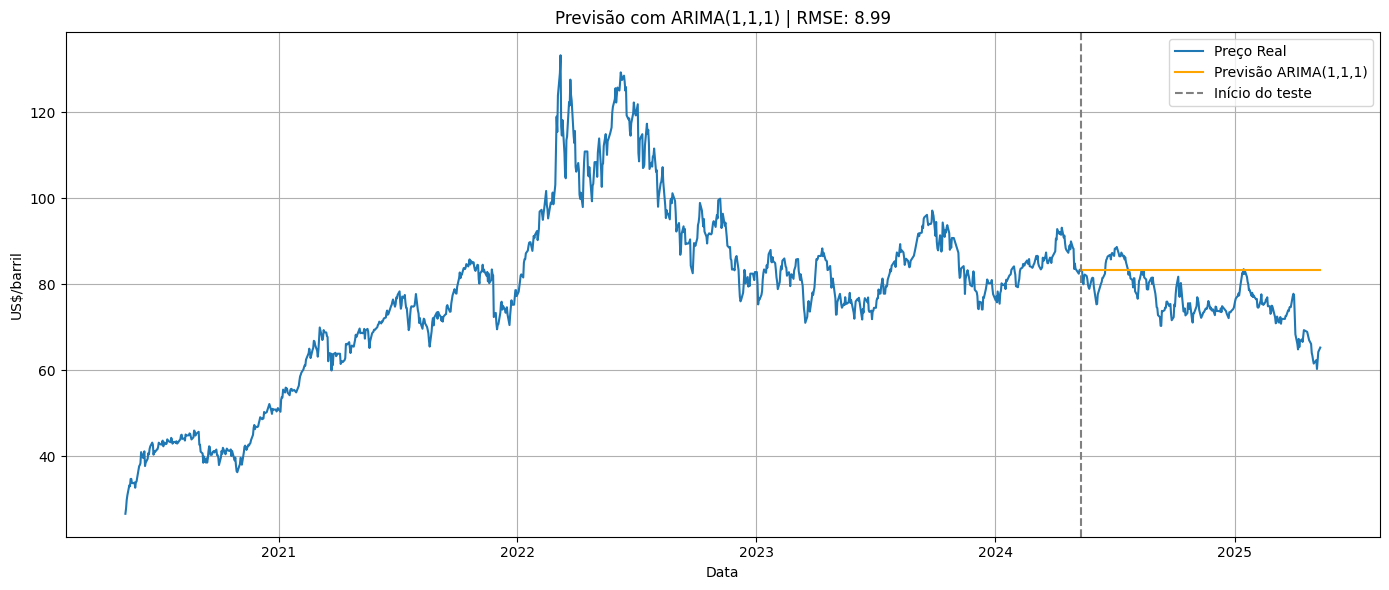

In [39]:
serie_full = serie.copy()

# Modelo ARIMA na série original com ordem (1,1,1)
model = ARIMA(serie_full[:split_index + 1], order=(1, 1, 1))
model_fit = model.fit()

forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)
forecast_index = serie_full.index[split_index + 1 : split_index + 1 + forecast_steps]
forecast = pd.Series(forecast, index=forecast_index)

# Avaliação com base na série original
real_test = serie_full[forecast_index[0]:forecast_index[-1]]
rmse = np.sqrt(mean_squared_error(real_test, forecast))
print(f"RMSE: {rmse:.2f}")

# Plot
plt.figure(figsize=(14, 6))
plt.plot(serie_full, label='Preço Real')
plt.plot(forecast, label='Previsão ARIMA(1,1,1)', color='orange')
plt.axvline(x=forecast_index[0], color='gray', linestyle='--', label='Início do teste')
plt.title(f'Previsão com ARIMA(1,1,1) | RMSE: {rmse:.2f}')
plt.xlabel('Data')
plt.ylabel('US$/barril')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



#### 3.1.2 ARIMA(2,1,1)

RMSE ARIMA(2,1,1): 8.95


c:\Users\marlo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\marlo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


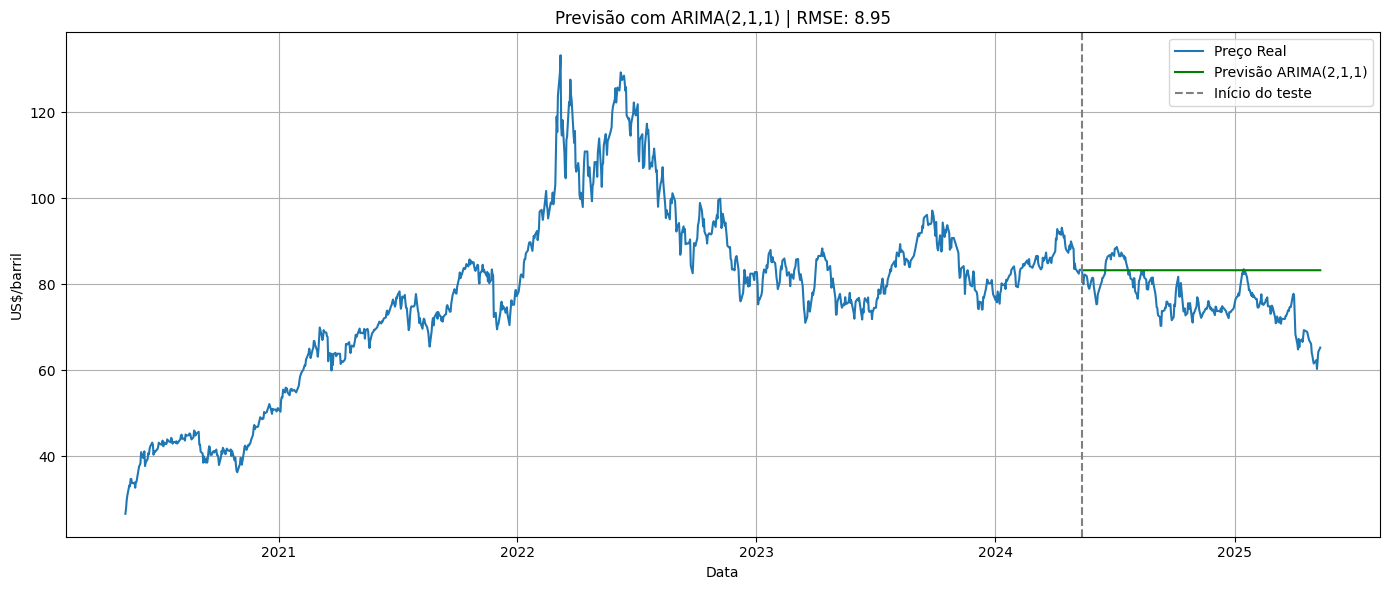

In [40]:
serie_full = serie.copy()

# Split treino/teste
split_index = int(len(serie_full) * 0.8)
forecast_steps = len(serie_full) - split_index
forecast_index = serie_full.index[split_index : split_index + forecast_steps]
real_test = serie_full[forecast_index[0]:forecast_index[-1]].dropna()

serie_treino = serie_full[:split_index + 1].dropna()

model_211 = ARIMA(serie_treino, order=(2, 1, 1))
model_fit_211 = model_211.fit()

forecast_211 = model_fit_211.forecast(steps=forecast_steps)
forecast_211 = pd.Series(forecast_211, index=forecast_index)

forecast_index = serie_full.index[split_index + 1 : split_index + 1 + forecast_steps]

forecast_211 = pd.Series(model_fit_211.forecast(steps=len(forecast_index)), index=forecast_index)

real_test = serie_full.loc[forecast_index].copy()
rmse_211 = np.sqrt(mean_squared_error(real_test, forecast_211))
print(f"RMSE ARIMA(2,1,1): {rmse_211:.2f}")

plt.figure(figsize=(14, 6))
plt.plot(serie_full, label='Preço Real')
plt.plot(forecast_211, label='Previsão ARIMA(2,1,1)', color='green')
plt.axvline(x=forecast_index[0], color='gray', linestyle='--', label='Início do teste')
plt.title(f'Previsão com ARIMA(2,1,1) | RMSE: {rmse_211:.2f}')
plt.xlabel('Data')
plt.ylabel('US$/barril')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Em ambas previsões com ARIMA obtivemos uma linha constante na previsão, o que pode indicar que o modelo está prevendo que não há tendência significativa e o melhor palpite dele é a média dos valores recentes.

### 3.2 Prophet

08:36:22 - cmdstanpy - INFO - Chain [1] start processing
08:36:23 - cmdstanpy - INFO - Chain [1] done processing


RMSE Prophet: 6.77


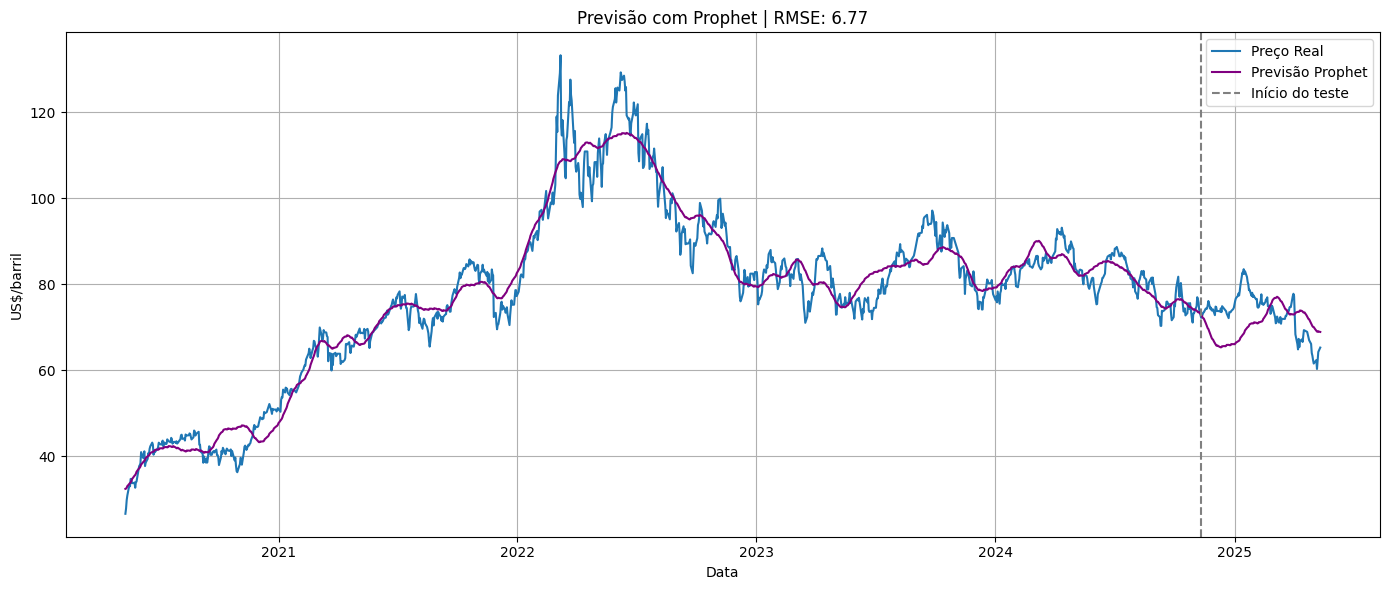

In [41]:
df_prophet = serie_full[serie_full.index >= serie_full.index.max() - pd.DateOffset(years=5)].reset_index()
df_prophet.columns = ['ds', 'y']

# Split treino/teste
split_index = int(len(df_prophet) * 0.9)
train_df = df_prophet.iloc[:split_index]
test_df = df_prophet.iloc[split_index:]

# Modelo
model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(train_df)

# Cria datas futuras para previsão
future = model_prophet.make_future_dataframe(periods=len(test_df), freq='D')
forecast = model_prophet.predict(future)

# Avaliação (apenas nos valores previstos)
forecast_prophet = forecast[['ds', 'yhat']].set_index('ds').loc[test_df['ds']]
rmse_prophet = np.sqrt(mean_squared_error(test_df['y'], forecast_prophet['yhat']))
print(f"RMSE Prophet: {rmse_prophet:.2f}")

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Preço Real')
plt.plot(forecast['ds'], forecast['yhat'], label='Previsão Prophet', color='purple')
plt.axvline(x=test_df['ds'].iloc[0], color='gray', linestyle='--', label='Início do teste')
plt.title(f'Previsão com Prophet | RMSE: {rmse_prophet:.2f}')
plt.xlabel('Data')
plt.ylabel('US$/barril')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


O forecast utilizando Prophet está suavizado demais em relaçao às oscilações reais e reage com atraso a quedas e picos reais.<br>
Indica tendência de alta na previsão com os dados de teste, o que não é refletido nos dados reais.

### 3.3 LSTM

c:\Users\marlo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
RMSE LSTM: 1.82


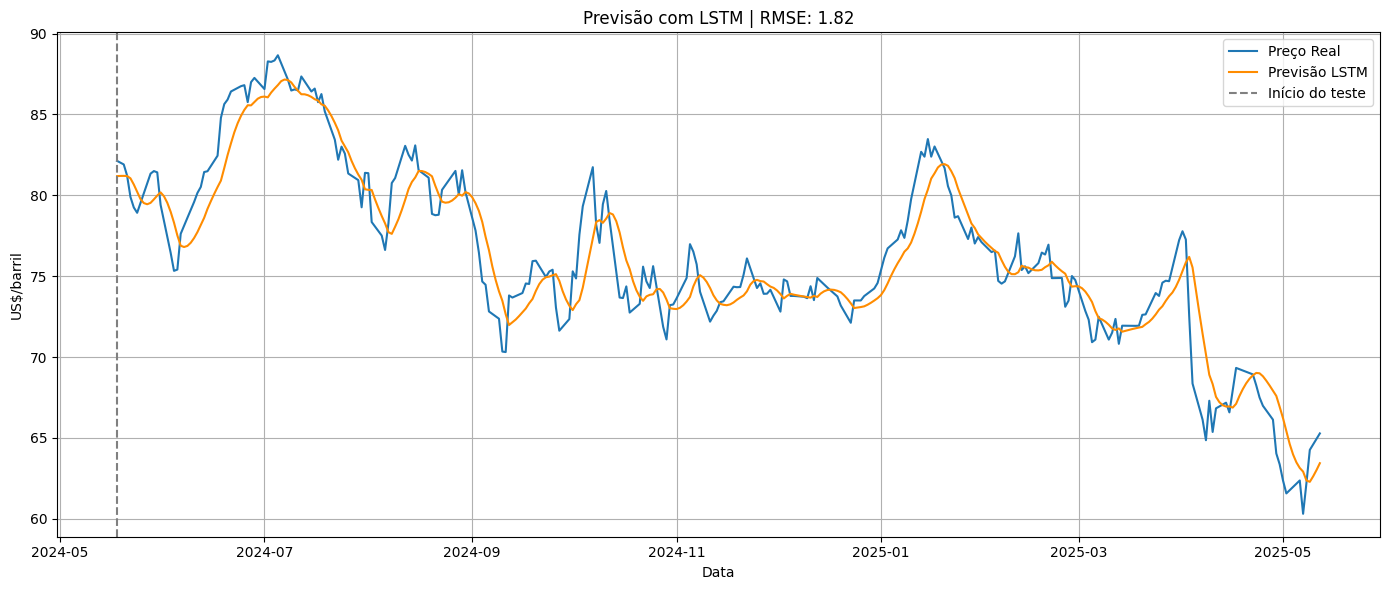

In [42]:
serie_lstm = serie_full[serie_full.index >= serie_full.index.max() - pd.DateOffset(years=5)].copy()
serie_lstm = serie_lstm.asfreq('D').interpolate()

# Normalização
scaler_lstm = MinMaxScaler()
scaled = scaler_lstm.fit_transform(serie_lstm.values.reshape(-1, 1))

# Função para criar sequência
def create_sequences(data, window=30):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Cria os dados com janela de 30 dias
X, y = create_sequences(scaled, window=30)

# Divide em treino e teste (80%)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

# Treina o modelo
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

# Previsões
y_pred_scaled = model_lstm.predict(X_test)
y_pred_lstm = scaler_lstm.inverse_transform(y_pred_scaled)
y_test_inv = scaler_lstm.inverse_transform(y_test)

# RMSE
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_lstm))
print(f"RMSE LSTM: {rmse_lstm:.2f}")


dates = serie_lstm.index[30 + split_index:] 
plt.figure(figsize=(14,6))
plt.plot(dates, y_test_inv, label='Preço Real')
plt.plot(dates, y_pred_lstm, label='Previsão LSTM', color='darkorange')
plt.axvline(x=dates[0], color='gray', linestyle='--', label='Início do teste')
plt.title(f'Previsão com LSTM | RMSE: {rmse_lstm:.2f}')
plt.xlabel('Data')
plt.ylabel('US$/barril')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


A curva prevista acompanha bem as oscilações reais, porém é perceptível pequenos atrasos de resposta.
Um modelo promissor

### 3.4 XGBoost

Para treinar o XGBoost de uma melhor forma, vamos adicionar alguns feats ao nosso modelo.

RMSE XGBoost: 1.10


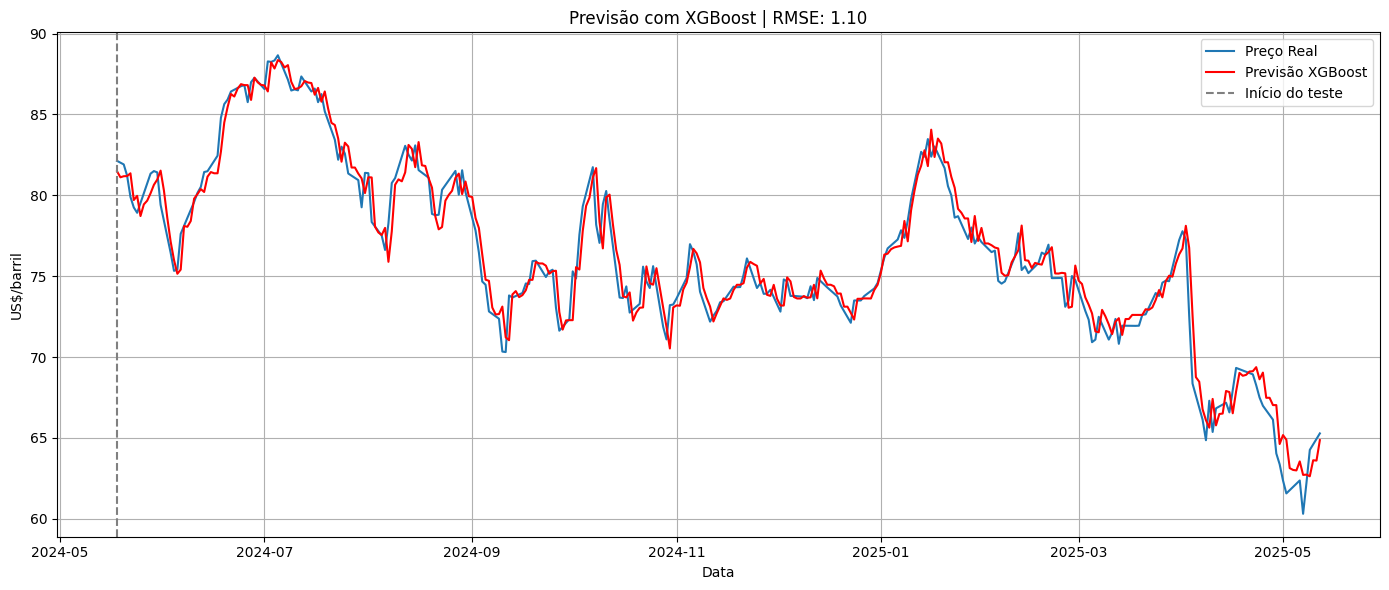

In [43]:
df_xgb = serie_full[serie_full.index >= serie_full.index.max() - pd.DateOffset(years=5)].copy()
df_xgb = df_xgb.asfreq('D').interpolate()

# Cria features
df_feat = df_xgb.copy()
df_feat = df_feat.to_frame(name='y')
df_feat['lag_1'] = df_feat['y'].shift(1)
df_feat['lag_7'] = df_feat['y'].shift(7)
df_feat['lag_30'] = df_feat['y'].shift(30)
df_feat['roll_mean_7'] = df_feat['y'].rolling(7).mean()
df_feat['roll_mean_30'] = df_feat['y'].rolling(30).mean()
df_feat['day_of_week'] = df_feat.index.dayofweek
df_feat['month'] = df_feat.index.month
df_feat = df_feat.dropna()

# Divide em treino/teste
split_idx = int(len(df_feat) * 0.8)
train, test = df_feat.iloc[:split_idx], df_feat.iloc[split_idx:]

X_train = train.drop(columns='y')
y_train = train['y']
X_test = test.drop(columns='y')
y_test = test['y']

# Modelo XGBoost
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
model_xgb.fit(X_train, y_train)

# Previsão
y_pred = model_xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE XGBoost: {rmse_xgb:.2f}")

plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Preço Real')
plt.plot(y_test.index, y_pred, label='Previsão XGBoost', color='red')
plt.axvline(x=y_test.index[0], color='gray', linestyle='--', label='Início do teste')
plt.title(f'Previsão com XGBoost | RMSE: {rmse_xgb:.2f}')
plt.xlabel('Data')
plt.ylabel('US$/barril')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Temos a linha de previsão muito próxima da previsão e um RMSE muito baixo indicando possível overfitting.<br>
Vamos alterar alguns parâmetros e adicionais mais lags para reduzirmos o overfitting para um nível mais realista.

RMSE XGBoost (com normalização): 1.74


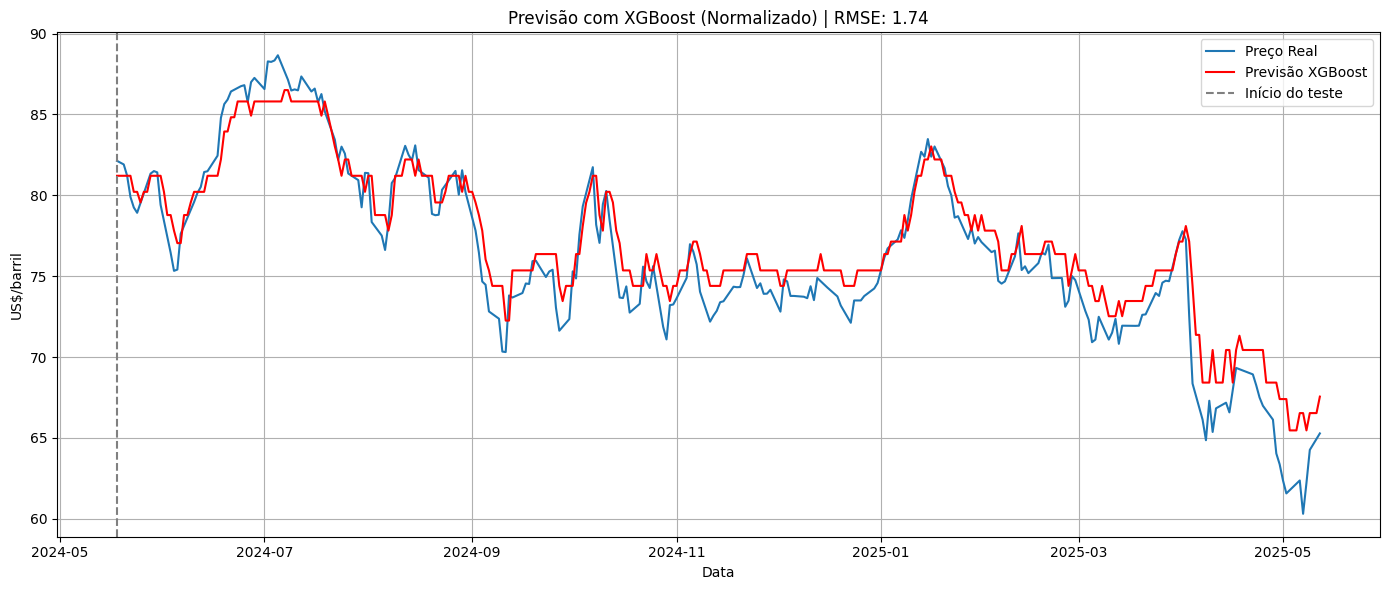

In [44]:
df_xgb = serie_full[serie_full.index >= serie_full.index.max() - pd.DateOffset(years=5)].copy()
df_xgb = df_xgb.asfreq('D').interpolate()

# Aplica MinMaxScaler à variável alvo (y)
scaler_xgb = MinMaxScaler()
df_scaled = scaler_xgb.fit_transform(df_xgb.values.reshape(-1, 1)).flatten()

# Substitui a série original pela normalizada
df_xgb_scaled = pd.Series(df_scaled, index=df_xgb.index)

# Cria features com base na série normalizada
df_feat = df_xgb_scaled.to_frame(name='y')
df_feat['lag_1'] = df_feat['y'].shift(1)
df_feat['lag_3'] = df_feat['y'].shift(3)
df_feat['lag_7'] = df_feat['y'].shift(7)
df_feat['lag_14'] = df_feat['y'].shift(14)
df_feat['lag_30'] = df_feat['y'].shift(30)
df_feat['roll_mean_7'] = df_feat['y'].rolling(7).mean()
df_feat['roll_mean_30'] = df_feat['y'].rolling(30).mean()
df_feat['roll_std_7'] = df_feat['y'].rolling(7).std()
df_feat['day_of_week'] = df_feat.index.dayofweek
df_feat['month'] = df_feat.index.month
df_feat['trend'] = np.arange(len(df_feat))
df_feat = df_feat.dropna()

# Divide em treino/teste
split_idx = int(len(df_feat) * 0.8)
train, test = df_feat.iloc[:split_idx], df_feat.iloc[split_idx:]

X_train = train.drop(columns='y')
y_train = train['y']
X_test = test.drop(columns='y')
y_test = test['y']

# Modelo XGBoost com hiperparâmetros ajustados
model_xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0.5,
    reg_lambda=1,
    random_state=75
)

model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Previsão (em escala normalizada)
y_pred_xgb_scaled = model_xgb.predict(X_test)

# Inverte normalização para avaliação e gráfico
y_pred_xgb = scaler_xgb.inverse_transform(y_pred_xgb_scaled.reshape(-1, 1)).flatten()
y_test_real = scaler_xgb.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

# Avaliação
rmse_xgb = np.sqrt(mean_squared_error(y_test_real, y_pred_xgb))
print(f"RMSE XGBoost (com normalização): {rmse_xgb:.2f}")

# Gráfico
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test_real, label='Preço Real')
plt.plot(y_test.index, y_pred_xgb, label='Previsão XGBoost', color='red')
plt.axvline(x=y_test.index[0], color='gray', linestyle='--', label='Início do teste')
plt.title(f'Previsão com XGBoost (Normalizado) | RMSE: {rmse_xgb:.2f}')
plt.xlabel('Data')
plt.ylabel('US$/barril')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Após as alterações, este modelo mostra seguir bem a tendência com menos overfitting do que o modelo anterior e responde bem a quedas e picos.

## 4. Comparação entre os Módelos

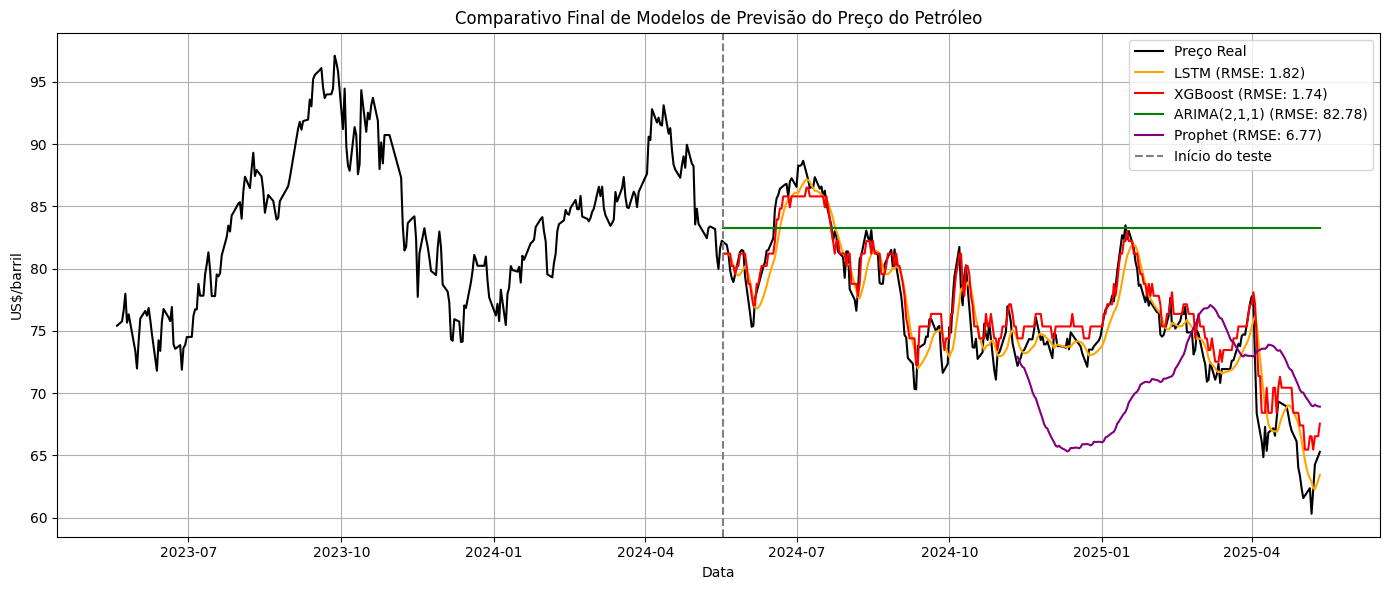

In [45]:
# Garantir que todas as previsões sejam Series com o mesmo índice de y_test
y_pred_lstm = pd.Series(y_pred_lstm.ravel(), index=y_test.index)
y_pred_xgb = pd.Series(y_pred_xgb.ravel(), index=y_test.index)
forecast_211 = pd.Series(forecast_211.squeeze(), index=forecast_index)

# Alinha todas com y_test
y_test_lstm, y_pred_lstm = y_test.align(y_pred_lstm, join='inner')
y_test_xgb, y_pred_xgb = y_test.align(y_pred_xgb, join='inner')
y_test_arima, forecast_211_aligned = y_test.align(forecast_211, join='inner')
y_test_prophet, forecast_prophet = y_test.align(forecast_prophet, join='inner')

# RMSEs
#rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
#rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))
#rmse_arima = np.sqrt(mean_squared_error(y_test_arima, forecast_211_aligned))
#rmse_prophet = np.sqrt(mean_squared_error(y_test_prophet, forecast_prophet))

# Estende o período para incluir contexto anterior ao teste
dias_contexto = 365
contexto_inicio = y_test.index[0] - pd.Timedelta(days=dias_contexto)
contexto_fim = y_test.index[-1]
preco_real_plot = serie_full[contexto_inicio:contexto_fim]

plt.figure(figsize=(14, 6))
plt.plot(preco_real_plot.index, preco_real_plot.values, label='Preço Real', color='black')

plt.plot(y_pred_lstm.index, y_pred_lstm, label=f'LSTM (RMSE: {rmse_lstm:.2f})', color='orange')
plt.plot(y_pred_xgb.index, y_pred_xgb, label=f'XGBoost (RMSE: {rmse_xgb:.2f})', color='red')
plt.plot(forecast_211_aligned.index, forecast_211_aligned, label=f'ARIMA(2,1,1) (RMSE: {rmse_arima:.2f})', color='green')
plt.plot(forecast_prophet.index, forecast_prophet, label=f'Prophet (RMSE: {rmse_prophet:.2f})', color='purple')

plt.axvline(x=y_test.index[0], color='gray', linestyle='--', label='Início do teste')
plt.title('Comparativo Final de Modelos de Previsão do Preço do Petróleo')
plt.xlabel('Data')
plt.ylabel('US$/barril')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Visualizando as previsões dos 4 modelos e seus respectivos RMSEs, podemos eleger LSTM e XGBoost como os melhores modelos para a previsão. <br>
Iremos utilizar ambos no deploy para comparativos.

# Exportação dos modelos escolhidos

In [27]:
# Salva o modelo XGBoost
joblib.dump(model_xgb, 'modelo_xgboost.pkl')
joblib.dump(scaler_xgb, 'scaler_xgb.pkl')


['scaler_xgb.pkl']

In [28]:
# Salva o modelo LSTM em formato keras
model_lstm.save('modelo_lstm.keras')
joblib.dump(scaler_lstm, "scaler_lstm.pkl")

['scaler_lstm.pkl']